# Notes #

- APIMetadata emulates a dictionary, except attributes cannot be accessed through indexing. Must use '.' to access attributes.

- To create an instance of pokemon requires the ID or name. I think the name attribute then copies this input.

- Several .csv have columns connected to each other [here](https://github.com/PokeAPI/pokedex/tree/master-pokeapi/pokedex/data/csv)
    - [pokemon.csv](https://github.com/PokeAPI/pokedex/blob/master-pokeapi/pokedex/data/csv/pokemon.csv)
    - [types.csv](https://github.com/PokeAPI/pokedex/blob/master-pokeapi/pokedex/data/csv/types.csv)
    - [pokemon_types.csv](https://github.com/PokeAPI/pokedex/blob/master-pokeapi/pokedex/data/csv/pokemon_types.csv)

- What are the rules for naming the sprite images?
    ```
    if (is_default):
        png_name = pokemon::id.png
    else:
        - look up the species name
        - in the current identifier, replace the species name with the species id
        - png_name = current identifier + .png
    ```

- [Pokemon with Form Differences](https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_with_form_differences)
    - I think it makes sense to process the exceptions found here, instead of trying to write a rule for them

In [1]:
!git clone https://github.com/PokeAPI/sprites.git

Cloning into 'sprites'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 46285 (delta 2), reused 13 (delta 0), pack-reused 46265
Receiving objects: 100% (46285/46285), 372.08 MiB | 36.25 MiB/s, done.
Resolving deltas: 100% (6458/6458), done.
Checking out files: 100% (43220/43220), done.


Cloning the [PokeAPI/sprites repo](https://github.com/PokeAPI/sprites) will download the `sprites` directory directly to the notebook workspace

In [2]:
!pip install pokebase 

In [3]:
#for reading in images
import matplotlib.image as mpimg
#for displaying images to screen
import matplotlib.pyplot as plt
#look up pokemon types
import pokebase as pb
#working with csv files
import numpy as np
import pandas as pd
import requests
import io
import re
import os

In [4]:
#sprites dirs
pokemon_dir = "/content/sprites/sprites/pokemon/"
front_dir = "/content/sprites/sprites/pokemon/front/"
back_dir = "/content/sprites/sprites/pokemon/back/"
female_dir = "/content/sprites/sprites/pokemon/female"
shiny_dir = "/content/sprites/sprites/pokemon/shiny"
all_sprites = [front_dir, back_dir, female_dir, shiny_dir]
#csv dirs
tables_dir = "/content/tables/"

In [5]:
#create `front` and `table` directories 
try:
    os.mkdir(front_dir)
    os.mkdir(tables_dir)
except FileExistsError:
    pass

In [6]:
#move front facing sprites to their own directory
for root, dirs, files in os.walk(pokemon_dir):
    for f in files:
        if ".png" in f:
            try:
                old = pokemon_dir+f
                new = front_dir+f
                os.rename(old, new)
            except FileNotFoundError:
                #file already moved
                pass

In [7]:
#download required csv files
csv_files = {"pokemon.csv":"https://raw.githubusercontent.com/PokeAPI/pokedex/master-pokeapi/pokedex/data/csv/pokemon.csv",
             "types.csv":"https://raw.githubusercontent.com/PokeAPI/pokedex/master-pokeapi/pokedex/data/csv/types.csv",
             "pokemon_types.csv":"https://raw.githubusercontent.com/PokeAPI/pokedex/master-pokeapi/pokedex/data/csv/pokemon_types.csv"}

for name, url in csv_files.items():
    url_contents = requests.get(url).content
    decoded_contents = io.StringIO(url_contents.decode("utf-8"))
    df = pd.read_csv(decoded_contents)
    df.to_csv(tables_dir+name)

In [8]:
def show_img(img_path):
    """
    Display the image at `img_path` on the screen. 

    Args:    
    img_path (str):  Path to image
    """

    img = mpimg.imread(img_path)
    plt.imshow(img);
    return

In [9]:
def pokemon_type_database(identifier):
    """
    Use Pokebase API to get a list of pokemon types 

    Args:
    identifier (str):  Name used to search Pokebase API
    """

    #create a pokemon object
    pkmn = pb.pokemon(identifier)
    #create a list of the types as strings
    return [str(t.type) for t in pkmn.types]

`type` is a built-in function for Python. Unfortunately, this is the required syntax for accessing a Pokemon's type attribute.

In [10]:
#create dataframes to work with csv files
pokemonDF = pd.read_csv(tables_dir+"pokemon.csv")
pokemon_typesDF = pd.read_csv(tables_dir+"pokemon_types.csv")
typesDF = pd.read_csv(tables_dir+"types.csv")

In [11]:
#select specific columns from each dataframe
pokemonDF = pokemonDF[["id", "identifier", "species_id", "is_default"]]
pokemon_typesDF = pokemon_typesDF[["pokemon_id", "type_id", "slot"]]
typesDF = typesDF[["id", "identifier"]]

In [12]:
def parse_for_id(filename):
    """
    Given a .PNG filename, search for an id number.
    Returns `None` if no id number can be found.

    Args:
    filename (str):  Full path to .PNG file in local directory

    Returns:
    (int):  The id as an integer
    (None):  If no id number can be found
    """

    pattern = r"\d+"
    found = re.findall(pattern, filename)
    if found:
        return int(found[0])
    else:
        return None
    #end parse_for_id

In [13]:
def is_in_pokemonDF(id):
    """
    Determine if the given id can be used to index `pokemon.csv`

    Args:
    id (int):  Numerical id specifying a pokemon to search

    Returns:
    (bool):  True if id is a key in `pokemon.csv`. Else, False.
    """

    available_ids = list(pokemonDF["id"].values)
    return id in available_ids

In [14]:
def get_type(pokemon_id):
    """
    Get the primary and secondary typing of a Pokemon from its pokemon_id.
    Uses `pokemon_types.csv` to lookup records.

    Args:
    pokemon_id (int):  The integer id value in `pokemon.csv`
    """
    return pokemon_typesDF[pokemon_typesDF["pokemon_id"]==pokemon_id]["type_id"].values

get_type(1)

array([12,  4])

In [15]:
def decode_type(ids):
    """
    Decode the Pokemon type(s) from numerical id

    Args:
    ids ([int]):  List of id numbers as integers
    """

    return [typesDF[typesDF["id"]==id]["identifier"].values[0] for id in ids]

decode_type([1,2,3])

['normal', 'fighting', 'flying']

In [16]:
#search a directory for filenames that can't be used to search `pokemon.csv`
unwanted_filenames = []
def find_unwanted_filenames(directory):
    for root, dirs, filenames in os.walk(directory):
        for f in filenames:
            possible_id = parse_for_id(f)
            if not is_in_pokemonDF(possible_id):
                unwanted_filenames.append(f)
    return 

In [17]:
#check for unique, unwanted filenames in all the main directories
for d in all_sprites:
    find_unwanted_filenames(d)
unwanted_filenames = list(set(unwanted_filenames))
unwanted_filenames

['0.png', 'egg.png', 'egg-manaphy.png', 'substitute.png']

In [18]:
#create a small dataset of filenames to test with
for _, _, filenames in os.walk(front_dir):
    small_filenames = [f for f in filenames[:10]]

In [19]:
small_filenames

['390.png',
 '745-midday.png',
 '536.png',
 '154.png',
 '65.png',
 '458.png',
 '710-super.png',
 '678.png',
 '518.png',
 '669-red.png']

In [20]:
for png_name in small_filenames:
    if png_name not in unwanted_filenames:
        try:
            id = parse_for_id(png_name)
            pokemon_types = pokemon_type_database(id)
            identifier = pokemonDF[pokemonDF["id"]==id]["identifier"].values[0]
            print(f"{identifier}:  {list(pokemon_types)}")
        except ValueError:
            print(png_name)

chimchar:  ['fire']
lycanroc-midday:  ['rock']
palpitoad:  ['water', 'ground']
meganium:  ['grass']
alakazam:  ['psychic']
mantyke:  ['water', 'flying']
pumpkaboo-average:  ['ghost', 'grass']
meowstic-male:  ['psychic']
musharna:  ['psychic']
flabebe:  ['fairy']


In [21]:
pokemonDF[pokemonDF["species_id"]==25]

,id,identifier,species_id,is_default
24,25,pikachu,25,1
977,10080,pikachu-rock-star,25,0
978,10081,pikachu-belle,25,0
979,10082,pikachu-pop-star,25,0
980,10083,pikachu-phd,25,0
981,10084,pikachu-libre,25,0
982,10085,pikachu-cosplay,25,0
991,10094,pikachu-original-cap,25,0
992,10095,pikachu-hoenn-cap,25,0
993,10096,pikachu-sinnoh-cap,25,0


In [22]:
def format_filename_for_database(filename):
    id = parse_for_id(filename)
    species_id = pokemonDF[pokemonDF["id"]==id]["species_id"].values[0]
    species = pokemonDF[pokemonDF["species_id"]==species_id]["identifier"].values[0]
    filename = re.sub(str(id), species, filename)
    return filename

print(format_filename_for_database("212-mega.png"))

scizor-mega.png


In [23]:
pokemon_type_database("pikachu-kalos-cap")

['electric']

In [24]:
pokemon_type_database("unown")

['psychic']

# Sieve Requirements #

- The `id` in the filename matches a `pokemon_id` in `pokemon_types.csv`
    - Example: "1.png"
- The filename contains the identifying type
    - Example:  "493-bug.png"
- PokeBase can be used to lookup the type if the `id` in the filename is replaced with the species name
    - Example:  "150-mega-x.png"
    - Example:  "3-mega.png"
    - Example:  "3-gmax.png"
    - Example:  "351-rainy.png"
- The `id` in the filename is a proxy for an `id` that can be looked up in `pokemon_types.csv`
    - Example:  "413-plant.png" --> "10004.png"
- The `id` is all that is needed, but the filename contributes extra information
    - Example:  "386-speed.png"
    - Example:  "201-a.png"

In [25]:
#pivoted version of pokemon_typesDF
types_pivot = pd.pivot_table(pokemon_typesDF, values="type_id", index=["pokemon_id"], columns=["slot"])
types_pivot

slot,1,2
pokemon_id,,
1,12.0,4.0
2,12.0,4.0
3,12.0,4.0
4,10.0,NaN
5,10.0,NaN
...,...,...
10216,9.0,16.0
10217,4.0,16.0
10218,2.0,17.0


In [26]:
def search_pivot(filename):
    id = parse_for_id(filename)
    try:
        encoded_types = types_pivot.loc[id].dropna()
        return decode_type(encoded_types)
    except:
        return None

In [27]:
search_pivot("1.png")

['grass', 'poison']

In [28]:
search_pivot(front_dir+"4.png")

['fire']

In [29]:
def search_filename(filename):
    #sanitize filename 
    filename = filename[:-4]
    filename_parts = filename.split('-')[1:]

    #key terms to look for
    possible_types = list(typesDF["identifier"])

    result = []
    for p in filename_parts:
        if p in possible_types:
            result.append(p)
    if len(result):
        return result
    else:
        return None

In [30]:
search_filename("493-bug.png")

['bug']

In [31]:
search_filename("1.png")

In [32]:
def search_pokebase(filename):
    id = parse_for_id(filename)
    
    #look for species_id
    species_id = pokemonDF[pokemonDF["id"]==id]["species_id"].values[0]
    #get the species identifier
    identifier = pokemonDF[pokemonDF["id"]==id]["identifier"].values[0]
    
    #string used to create pokebase object
    pokebase_query = re.sub(str(id), identifier, filename)[:-4]
    try:
        pokemon = pb.pokemon(pokebase_query)
        return [str(t.type) for t in pokemon.types]
    except:
        return None

In [33]:
search_pokebase("150-mega-x.png")

['psychic', 'fighting']

In [34]:
search_pokebase("3-gmax.png")

['grass', 'poison']

In [35]:
search_pokebase("351-rainy.png")

['water']

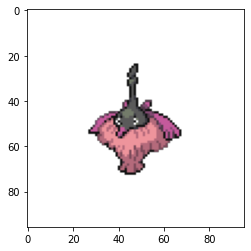

In [36]:
show_img(front_dir+"10005.png")

In [37]:
def search_all(filename):
    cand0 = search_pokebase(filename)
    cand1 = search_filename(filename)
    cand2 = None #search_pivot(filename)
    return [cand0, cand1, cand2]

In [38]:
for _, _, filenames in os.walk(front_dir):
    random_file_indices = np.random.randint(0, len(filenames), (50))
    files = [filenames[i] for i in random_file_indices]
    
    for name in files:
        result = search_all(name)
        print(f"{name}:  {result}")

773-normal.png:  [None, ['normal'], None]
666-savanna.png:  [None, None, None]
210.png:  [['fairy'], None, None]
380-mega.png:  [['dragon', 'psychic'], None, None]
878.png:  [['steel'], None, None]
732.png:  [['normal', 'flying'], None, None]
254-mega.png:  [['grass', 'dragon'], None, None]
319.png:  [['water', 'dark'], None, None]
670-red.png:  [None, None, None]
402.png:  [['bug'], None, None]
10073.png:  [['normal', 'flying'], None, None]
777.png:  [['electric', 'steel'], None, None]
493.png:  [['normal'], None, None]
212.png:  [['bug', 'steel'], None, None]
418.png:  [['water'], None, None]
54.png:  [['water'], None, None]
297.png:  [['fighting'], None, None]
744.png:  [['rock'], None, None]
173.png:  [['fairy'], None, None]
811.png:  [['grass'], None, None]
862.png:  [['dark', 'normal'], None, None]
10185.png:  [['psychic', 'ghost'], None, None]
9-mega.png:  [['water'], None, None]
10051.png:  [['psychic', 'fairy'], None, None]
144.png:  [['ice', 'flying'], None, None]
479-fan.png

In [39]:
foo = pokemonDF[pokemonDF["species_id"]==25]
for i in list(foo["id"]):
    print(search_all(str(i)+".png"))

[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]
[['electric'], None, None]


In [40]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/PokeAPI/pokedex/master-pokeapi/pokedex/data/csv/pokemon_form_names.csv")

In [41]:
df["pokemon_name"].unique()

array([nan, 'Zarbi A', 'Unown A', 'Deoxys Normal', 'Normal Deoxys',
       'Cheniti Plante', 'Plant Burmy', 'Cheniselle Plante',
       'Plant Wormadam', 'Ceriflor Couvert', 'Overcast Cherrim',
       'Sancoki Occident', 'West Shellos', 'Tritosor Occident',
       'West Gastrodon', 'Giratina Alternative', 'Altered Giratina',
       'Shaymin Terrestre', 'Land Shaymin', 'Arceus Normal',
       'Normal Arceus', 'Bargantua Rouge', 'Red-Striped Basculin',
       'Darumacho Normal', 'Standard Darmanitan', 'Vivaldaim Printemps',
       'Spring Deerling', 'Haydaim Printemps', 'Spring Sawsbuck',
       'Boréas Avatar', 'Incarnate Tornadus', 'Fulguris Avatar',
       'Incarnate Thundurus', 'Démétéros Avatar', 'Incarnate Landorus',
       'Keldeo Normal', 'Ordinary Keldeo', 'Meloetta Chant',
       'Aria Meloetta', 'Prismillon Floraison', 'Meadow Vivillon',
       'Flabébé Rouge', 'Red Flabébé', 'Floette Rouge', 'Red Floette',
       'Florges Rouge', 'Red Florges', 'Couafarel Sauvage',
       'Na